# **Rough Analysis**

This Jupyter Notebook consists of my first attempt of this project. It can be considered an exploration of a personal project idea that eventually became my CSIS 3290 Machine Learning Project.

## **Setup**

In [1]:
import pandas as pd
import numpy as np
from time import time
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from string import punctuation
punctuation = list(punctuation)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## **Vertuo**
Example Coffee: Intenso

### Data Preparation

In [2]:
dfVertuo_Raw = pd.read_excel("Dataset/CoffeeData.xlsx", index_col=False, sheet_name="Vertuo");
dfVertuo_Raw = dfVertuo_Raw[dfVertuo_Raw["Status"] == "Current"];
print(dfVertuo_Raw.columns)
dfVertuo_Raw[0:1]

Index(['ID', 'Name', 'Type', 'Serving', 'Serving Size', 'Headline',
       'Intensity', 'Sleeve Price', 'Per Capsule Price', 'Caption', 'Taste',
       'Best Served As', 'Notes', 'Acidity', 'Bitterness', 'Roastness', 'Body',
       'Milky Taste', 'Bitterness with Milk', 'Roastiness with Milk',
       'Creamy Texture', 'Ingredients & Allergens',
       'Number of Capsules per Sleeve',
       'Net Weight per Total Number of Capsules', 'Capsule Image Link',
       'Capsule & Sleeve Image Link', 'Decaf Coffee?', 'Category',
       'Other Information', 'Status'],
      dtype='object')


,ID,Name,Type,Serving,Serving Size,Headline,Intensity,Sleeve Price,Per Capsule Price,Caption,...,Creamy Texture,Ingredients & Allergens,Number of Capsules per Sleeve,Net Weight per Total Number of Capsules,Capsule Image Link,Capsule & Sleeve Image Link,Decaf Coffee?,Category,Other Information,Status
0,VL01,Intenso,Vertuo,Coffee,230ml,Smooth & Strong,9.0,12.6,1.26,Why we love it: Try Intenso - a Vertuo coffee ...,...,NaN,Roast and ground coffee,10,125 g,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,No,Signature Coffee,NaN,Current


In [3]:
def process_text_for_NLP_Vertuo(df_Raw):
    # Columns used for NLP:
    # NLPColumns_Vertuo = ["Type","Serving","Headline","Caption","Taste","Best Served As","Notes","Ingredients & Allergens","Category"];
    NLPColumns_Vertuo = ["Serving","Headline","Caption","Taste","Best Served As","Notes","Category"];

    # NLP Pre-Processing:
    df_Prep = df_Raw.copy();
    df_Prep["Textual Info"] = "";
    for i in df_Prep.index:
        textualInfo = "";
        for col in NLPColumns_Vertuo:
            textualInfo += str(df_Prep.loc[i, col]).lower() + " ";
        textualInfo = textualInfo[:-1];
        textualInfo_tokens = word_tokenize(textualInfo);
        textualInfo_cleanedTokens = [];
        for token in textualInfo_tokens:
            token = lemmatizer.lemmatize(token, pos="a");
            if (token not in stop_words) and (token not in punctuation):
                token = re.sub(r'[^\w\s]', '', token);
                if token != '':
                    # textualInfo_cleanedTokens.append(token);
                    if str(nlp(token)[0].pos_) not in ["PNP","PNQ","PNX","POS","AVQ","CJC","CJS","CJT","DTQ","ITJ","PRF","PRP"]:
                        textualInfo_cleanedTokens.append(token);
        textualInfo_final = "";
        for token in textualInfo_cleanedTokens:
            textualInfo_final += token + " ";
        textualInfo_final = textualInfo_final[:-1];
        df_Prep.loc[i, "Textual Info"] = textualInfo_final;
    
    return df_Prep;

dfVertuo_Prep = process_text_for_NLP_Vertuo(dfVertuo_Raw);
print(dfVertuo_Prep.loc[0, "Textual Info"]);
dfVertuo_Prep[0:1]

coffee smooth strong love try intenso vertuo coffee dense dark night glowing golden brown sugar notes blend guatemalan washed robusta coffee beans latin american arabica thick roasted notes lingering finish split roast nespresso intenso blend arabicas get dark roast low acidity bring brown sugar aroma guatemalan coffee gets long roast develop robusta coffee beans bold bitter notes intense long black distinctly lingering aftertaste thick coffee crema coffee 230ml intense signature coffee


,ID,Name,Type,Serving,Serving Size,Headline,Intensity,Sleeve Price,Per Capsule Price,Caption,...,Ingredients & Allergens,Number of Capsules per Sleeve,Net Weight per Total Number of Capsules,Capsule Image Link,Capsule & Sleeve Image Link,Decaf Coffee?,Category,Other Information,Status,Textual Info
0,VL01,Intenso,Vertuo,Coffee,230ml,Smooth & Strong,9.0,12.6,1.26,Why we love it: Try Intenso - a Vertuo coffee ...,...,Roast and ground coffee,10,125 g,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,No,Signature Coffee,NaN,Current,coffee smooth strong love try intenso vertuo c...


In [4]:
def get_tasteProfileComparison(df, coffee_select, coffee_recommend):
    id_select = df[df["Name"] == coffee_select].index.astype('Int64')[0];
    id_recommend = df[df["Name"] == coffee_recommend].index.astype('Int64')[0];

    tasteCols = ["Acidity","Bitterness","Roastness","Body"];
    tasteCols_barista = ["Milky Taste","Bitterness with Milk","Roastiness with Milk", "Creamy Texture"];

    if df.loc[id_select, "Category"] == df.loc[id_recommend, "Category"]:
        if df.loc[id_select, "Category"] == "Barista Creations":
            cols = tasteCols_barista;
        else:
            cols = tasteCols;
        
        data = [];
        for id in [id_select, id_recommend]:
            for col in cols:
                row = [
                    df.loc[id, "Name"],
                    col,
                    df.loc[id, col]
                ];
                data.append(row);
        dfTaste = pd.DataFrame(data, columns=["Coffee","Metric","Value"]);
        fig = px.bar(dfTaste, x="Metric", y="Value", color="Coffee", barmode="group");
        return fig;

get_tasteProfileComparison(dfVertuo_Prep, "Intenso", "Melozio")

### Natural Language Processing

#### ***Wordcloud***
Example Coffee: Intenso

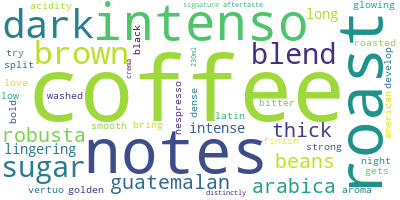

In [5]:
def get_wordcloud_Vertuo(df_Prep, coffee_select):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color="steelblue");
    mask = df_Prep["Name"] == coffee_select;
    idx = df_Prep.index[mask].tolist()[0];
    wc = wordcloud.generate(df_Prep.loc[idx, "Textual Info"]);
    return wc.to_image();

df_Prep = dfVertuo_Prep;
coffee_select = "Intenso";

get_wordcloud_Vertuo(df_Prep, coffee_select)

#### ***Named Entity Recognition (NER)***
Example Coffee: Odacio

In [6]:
def get_NER_Vertuo(df_Prep, coffee_select):
    mask = df_Prep["Name"] == coffee_select;
    idx = df_Prep.index[mask].tolist()[0];

    # nlp = spacy.load("en_core_web_sm");
    doc = nlp(df_Prep.loc[idx, "Textual Info"]);

    data = [];
    for token in doc:
        row = [token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop];
        data.append(row);
    df_NER = pd.DataFrame(data, columns=["TEXT","LEMMA","POS","TAG","DEP","SHAPE","ALPHA","STOP"]);
    return df_NER;

df_Prep = dfVertuo_Prep;
coffee_select = "Odacio";

# Column definitions:
# Text: The original word text.
# Lemma: The base form of the word.
# POS: The simple UPOS part-of-speech tag.
# Tag: The detailed part-of-speech tag.
# Dep: Syntactic dependency, i.e. the relation between tokens.
# Shape: The word shape – capitalization, punctuation, digits.
# is alpha: Is the token an alpha character?
# is stop: Is the token part of a stop list, i.e. the most common words of the language?

get_NER_Vertuo(df_Prep, coffee_select)

,TEXT,LEMMA,POS,TAG,DEP,SHAPE,ALPHA,STOP
0,coffee,coffee,NOUN,NN,nmod,xxxx,True,False
1,bold,bold,ADJ,JJ,amod,xxxx,True,False
2,lively,lively,ADJ,JJ,amod,xxxx,True,False
3,love,love,NOUN,NN,nmod,xxxx,True,False
4,odacio,odacio,X,FW,nmod,xxxx,True,False
...,...,...,...,...,...,...,...,...
62,coffee,coffee,NOUN,NN,nmod,xxxx,True,False
63,230ml,230ml,NOUN,NN,nmod,dddxx,False,False
64,intense,intense,ADJ,JJ,amod,xxxx,True,False
65,signature,signature,NOUN,NN,compound,xxxx,True,False


#### ***Term Frequency-Inverse Document Frequency (TF-IDF)***
Example Coffee: Melozio

##### Recommendations

In [7]:
def get_dataframeNLP_Vertuo(df_Prep, coffee_select):
    df_coffeeSelect = df_Prep[df_Prep["Name"] == coffee_select];
    df_NLP = pd.concat([df_coffeeSelect, df_Prep]);
    df_NLP = df_NLP.drop_duplicates();
    df_NLP = df_NLP[df_NLP.columns.tolist()[1:]];
    df_NLP = df_NLP.reset_index();
    return df_NLP;

def get_recommendations_Vertuo(df_NLP, coffee_select, numRec, indices, cosine_sim):
    idx = indices[coffee_select];
    sim_scores = list(enumerate(cosine_sim[idx]));
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True);
    sim_scores = sim_scores[1:numRec+1];
    coffee_indices = [i[0] for i in sim_scores];
    df_Rec = df_NLP[["Name","Serving","Headline","Intensity","Category"]].iloc[coffee_indices];
    
    similarityScores = [];
    for i in range(len(sim_scores)):
        similarityScores.append(round(sim_scores[i][1], 4));
    df_Rec["Similarity Score"] =  similarityScores;
    
    df_Rec = df_Rec.reset_index().rename(columns={"index":"id"});
    
    return df_Rec;

def get_recommendationResultsTFIDF_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper):
    df_NLP = get_dataframeNLP_Vertuo(df_Prep, coffee_select);
        
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, ngram_range=(n_lower, n_upper));
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    cosine_sim = linear_kernel(matrix, matrix);
    indices = pd.Series(df_NLP.index, index=df_NLP["Name"]).drop_duplicates();
    
    df_Rec = get_recommendations_Vertuo(df_NLP, coffee_select, numRec, indices, cosine_sim);
    
    return df_Rec;

# General Parameters:
df_Prep = dfVertuo_Prep;
coffee_select = "Melozio";
numRec = 10;
min_df = 2;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
# Unique Parameters:
sublinear_tf = True;

get_recommendationResultsTFIDF_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper)

,id,Name,Serving,Headline,Intensity,Category,Similarity Score
0,5,Melozio Decaffeinato,Coffee,Smooth & Balanced,6.0,Signature Coffee,0.9051
1,26,Carafe Pour-Over Style Mild,Carafe,Toasted Cereal & Malted,NaN,Craft Brew,0.6551
2,6,Half Caffeinato,Coffee,Sweet & Velvety,5.0,Signature Coffee,0.4887
3,24,Double Espresso Dolce,Double Espresso,Cereal & Mild,5.0,Double Espresso,0.4709
4,2,Stormio,Coffee,Rich & Strong,8.0,Signature Coffee,0.4439
5,17,Diavolitto,Espresso,Highly Intense & Powerful,11.0,Espresso,0.4188
6,1,Intenso,Coffee,Smooth & Strong,9.0,Signature Coffee,0.3991
7,29,Bianco Forte,Coffee,Full & Balanced; For Intense Recipes With Milk,NaN,Barista Creations,0.3987
8,33,Chocolate Fudge,Coffee,Sweet & Velvety; Dark Chocolate Flavoured,NaN,Barista Creations,0.3924
9,30,Vanilla Custard Pie,Coffee,Sweet & Velvety; Vanilla Flavoured,NaN,Barista Creations,0.3902


##### Feature Results

In [8]:
def get_FeatureResultsTFIDF_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper):
    df_NLP = get_dataframeNLP_Vertuo(df_Prep, coffee_select);
        
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, ngram_range=(n_lower, n_upper));
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    df_Feature = pd.DataFrame(matrix[0].T.todense(), 
        index=vectorizer.get_feature_names_out(), 
        columns=["TF-IDF"]
    );
    df_Feature = df_Feature.sort_values('TF-IDF', ascending=True);
    df_Feature = df_Feature[df_Feature["TF-IDF"] > 0];
    return df_Feature;

# General Parameters:
df_Prep = dfVertuo_Prep;
coffee_select = "Melozio";
numRec = 10;
min_df = 2;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
# Unique Parameters:
sublinear_tf = True;

get_FeatureResultsTFIDF_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper)

,TF-IDF
notes,0.120499
blend,0.120499
love,0.131948
split,0.131948
sweet,0.155262
230ml,0.160796
latin,0.173065
signature,0.204592
balanced,0.204592
note,0.210201


In [9]:
df_featureTFIDF = get_FeatureResultsTFIDF_Vertuo(df_Prep, "Melozio", numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper)
fig = px.bar(
    df_featureTFIDF,
    x="TF-IDF",
    y=df_featureTFIDF.index,
    orientation="h",
    labels={'index':'Features', 'TF-IDF':'Score'},
    title='Important Features (TF-IDF)'
)
fig.show()

#### ***Bag of Words***
Example Coffee: Stormio

In [10]:
def get_recommendationResultsBagOfWords_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper):
    df_NLP = get_dataframeNLP_Vertuo(df_Prep, coffee_select);
    
    # vectorizer = CountVectorizer(analyzer='word', token_pattern=token_pattern, ngram_range=(n_lower, n_upper));
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, analyzer=analyzer, token_pattern=token_pattern, ngram_range=(n_lower, n_upper));
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    cosine_sim = cosine_similarity(matrix, matrix);
    indices = pd.Series(df_NLP.index, index=df_NLP["Name"]).drop_duplicates();
    
    df_Rec = get_recommendations_Vertuo(df_NLP, coffee_select, numRec, indices, cosine_sim);
    
    return df_Rec;

# General Parameters:
df_Prep = dfVertuo_Prep;
coffee_select = "Stormio";
numRec = 10;
min_df = 5;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
# Unique Parameters:
analyzer = "word";
token_pattern = r"\b[a-zA-Z]{3,}\b";

get_recommendationResultsBagOfWords_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper)

,id,Name,Serving,Headline,Intensity,Category,Similarity Score
0,26,Carafe Pour-Over Style Mild,Carafe,Toasted Cereal & Malted,NaN,Craft Brew,0.6286
1,1,Intenso,Coffee,Smooth & Strong,9.0,Signature Coffee,0.6110
2,10,Odacio,Coffee,Bold & Lively,7.0,Signature Coffee,0.5890
3,29,Bianco Forte,Coffee,Full & Balanced; For Intense Recipes With Milk,NaN,Barista Creations,0.5451
4,9,Solelio,Coffee,Fruity & Lightly-Bodied,2.0,Signature Coffee,0.5388
5,22,Orafio,Espresso,Caramel & Roasted,6.0,Espresso,0.5230
6,34,Bianco Piccolo,Espresso,Sweet & Smooth,NaN,Barista Creations,0.5117
7,8,Inizio,Gran Lungo,Floral & Cereal,4.0,Gran Lungo,0.5018
8,16,Il Caffè,Espresso,Exceptionally Intense & Velvety,11.0,Espresso,0.4875
9,6,Half Caffeinato,Coffee,Sweet & Velvety,5.0,Signature Coffee,0.4857


##### Feature Results

In [11]:
def get_FeatureResultsBagOfWords_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper):
    df_NLP = get_dataframeNLP_Vertuo(df_Prep, coffee_select);
        
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, analyzer=analyzer, token_pattern=token_pattern, ngram_range=(n_lower, n_upper));
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    df_Feature = pd.DataFrame(matrix[0].T.todense(), 
        index=vectorizer.get_feature_names_out(), 
        columns=["Bag of Words"]
    );
    df_Feature = df_Feature.sort_values('Bag of Words', ascending=False);
    df_Feature = df_Feature[df_Feature["Bag of Words"] > 0];
    return df_Feature;

# General Parameters:
df_Prep = dfVertuo_Prep;
coffee_select = "Stormio";
numRec = 10;
min_df = 5;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
# Unique Parameters:
analyzer = "word";
token_pattern = r"\b[a-zA-Z]{3,}\b";

get_FeatureResultsBagOfWords_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper)

,Bag of Words
coffees,2
arabica,2
notes,2
roast,2
roasted,2
smooth,1
intense,1
fullbodied,1
milk,1
long,1


### Machine Learning & Validation

#### TF-IDF

Text(0.5, 1.0, 'Sparse Matrix Sample')

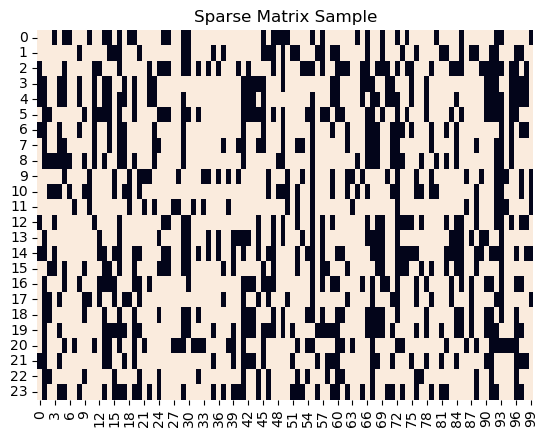

In [12]:
def getTrainTest(df_Prep, test_size):
    df_Train, df_Test = train_test_split(df_Prep, test_size=0.3);
    return df_Train, df_Test;

def getSparseMatrixTFIDF(df_Prep, test_size, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper):
    df_Train, df_Test = getTrainTest(df_Prep, test_size);
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, ngram_range=(n_lower, n_upper));
    X_train = vectorizer.fit_transform(df_Train["Textual Info"]);
    fig = sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');
    return fig;

# General Parameters:
df_Prep = dfVertuo_Prep;
test_size = 0.3;
min_df = 2;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
# Unique Parameters:
sublinear_tf = True;

getSparseMatrixTFIDF(df_Prep, test_size, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper)

C:\Users\kunal\AppData\Local\Temp\ipykernel_7332\220373274.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kunal\AppData\Local\Temp\ipykernel_7332\220373274.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kunal\AppData\Local\Temp\ipykernel_7332\220373274.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kunal\AppData\Local\Temp\ipykernel_7332\220373274.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kunal\AppData\Local\Temp\ipykernel_7332\220373274.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

# Carafe:
  . selected features: 0
  . top features: 
 
# Coffee:
  . selected features: 0
  . top features: 
 
# Double Espresso:
  . selected features: 1
  . top features: double
 
# Espresso:
  . selected features: 0
  . top features: 
 
# Gran Lungo:
  . selected features: 3
  . top features: gran,lungo,floral
 


Text(0.5, 1.0, 'Sparse Matrix Sample')

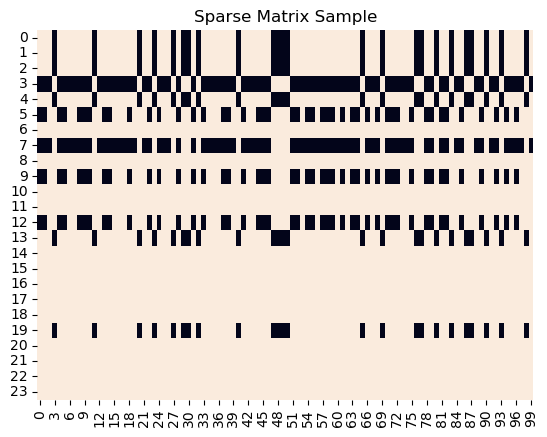

In [13]:
def getSparseMatrixTFIDF_FeatureSelection(df_Prep, test_size, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, p_value_limit):
    df_Train, df_Test = getTrainTest(df_Prep, test_size);
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, ngram_range=(n_lower, n_upper));
    X_train = vectorizer.fit_transform(df_Train["Textual Info"]);
    
    y = df_Train["Serving"];
    X_names = vectorizer.get_feature_names_out();
    dtf_features = pd.DataFrame()
    for cat in np.unique(y):
        chi, p = chi2(X_train, y==cat)
        dtf_features = dtf_features.append(pd.DataFrame(
                    {"feature":X_names, "score":1-p, "y":cat}))
        dtf_features = dtf_features.sort_values(["y","score"], 
                        ascending=[True,False])
        dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    X_names = dtf_features["feature"].unique().tolist()
    
    for cat in np.unique(y):
        print("# {}:".format(cat))
        print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
        print("  . top features:", ",".join(
        dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
        print(" ")
    
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, vocabulary=X_names);
    X_train = vectorizer.fit_transform(df_Train["Textual Info"]);
    fig = sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');

    return fig;

# General Parameters:
df_Prep = dfVertuo_Prep;
test_size = 0.3;
min_df = 2;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
p_value_limit = 0.95;
# Unique Parameters:
sublinear_tf = True;

getSparseMatrixTFIDF_FeatureSelection(df_Prep, test_size, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, p_value_limit)

##### Modeling

###### Multinomial NB and Cross Validation

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dfVertuo_Prep["Textual Info"], dfVertuo_Prep["Serving"], test_size=0.3, random_state=42)
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('mulNB', MultinomialNB())
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mulNB', MultinomialNB())])

In [15]:
pipe.score(X_test, y_test)

0.36363636363636365

In [16]:
parameters = {
    'mulNB__alpha': [1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.03, 0.01] 
}

grid = GridSearchCV(pipe, param_grid=parameters, cv=10, refit=True)
t0 = time()
grid.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print(grid.best_score_)
print(grid.best_params_)

c:\Users\kunal\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



done in 2.779s
0.5833333333333333
{'mulNB__alpha': 0.03}


In [17]:
grid.score(X_test, y_test)

0.6363636363636364

## **Original**

### Data Preparation

In [18]:
dfOriginal_Raw = pd.read_excel("Dataset/CoffeeData.xlsx", index_col=False, sheet_name="Original");
dfOriginal_Raw = dfOriginal_Raw[dfOriginal_Raw["Status"] == "Current"];
print(dfOriginal_Raw.columns)
dfOriginal_Raw[0:1]

Index(['ID', 'Name', 'Type', 'Serving', 'Serving Size', 'Headline',
       'Intensity', 'Sleeve Price', 'Per Capsule Price', 'Caption', 'Taste',
       'Best Served As', 'Notes', 'Acidity', 'Bitterness', 'Roastness', 'Body',
       'Milky Taste', 'Bitterness with Milk', 'Roastiness with Milk',
       'Creamy Texture', 'Ingredients & Allergens',
       'Number of Capsules per Sleeve',
       'Net Weight per Total Number of Capsules', 'Capsule Image Link',
       'Capsule & Sleeve Image Link', 'Decaf Coffee?', 'Category',
       'Other Information', 'Status'],
      dtype='object')


,ID,Name,Type,Serving,Serving Size,Headline,Intensity,Sleeve Price,Per Capsule Price,Caption,...,Creamy Texture,Ingredients & Allergens,Number of Capsules per Sleeve,Net Weight per Total Number of Capsules,Capsule Image Link,Capsule & Sleeve Image Link,Decaf Coffee?,Category,Other Information,Status
0,OL1,Inspirazione Napoli,Original,Espresso,40ml,Dark & Creamy,13.0,8.7,0.87,The most intense and darkest roast in this ran...,...,NaN,Roast and ground coffee,10,57 g,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,No,Inspirazione Italiana,NaN,Current


In [19]:
dfOriginal_Prep = process_text_for_NLP_Vertuo(dfOriginal_Raw);
print(dfOriginal_Prep.loc[0, "Textual Info"]);
dfOriginal_Prep[0:1]

espresso dark creamy the most intense and dark roast in this range inspired by the capital of coffee reveals the deeprooted roasting traditions of naples its depth of character should come as no surprise ispirazione napoli pays tribute to the short strong and dark espressos of this southern italian coastal city it a velvety creamy cup with an extremely thick body and a kiss of pleasant bitterness in its aftertaste a velvety creamy cup with an extremely thick body and pleasantly bitter cocoa notes ristretto 25ml espresso 40ml intense roasted inspirazione italiana


,ID,Name,Type,Serving,Serving Size,Headline,Intensity,Sleeve Price,Per Capsule Price,Caption,...,Ingredients & Allergens,Number of Capsules per Sleeve,Net Weight per Total Number of Capsules,Capsule Image Link,Capsule & Sleeve Image Link,Decaf Coffee?,Category,Other Information,Status,Textual Info
0,OL1,Inspirazione Napoli,Original,Espresso,40ml,Dark & Creamy,13.0,8.7,0.87,The most intense and darkest roast in this ran...,...,Roast and ground coffee,10,57 g,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,No,Inspirazione Italiana,NaN,Current,espresso dark creamy the most intense and dark...


## **Export Data**

In [20]:
# dfVertuo_Prep.to_csv("data/PreparedCoffeeData.csv", index=False)
# dfCoffee_Prep = pd.concat([dfVertuo_Prep, dfOriginal_Prep]);
# dfCoffee_Prep = dfCoffee_Prep.reset_index(drop=True);
# dfCoffee_Prep.to_csv("data/PreparedCoffeeData.csv", index=False);